# Chapter 5.5. Censored Data
- Cha Sa Soon Dataset

In [41]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [42]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'

In [43]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; 
import arviz
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

numpyro.set_platform('gpu')
numpyro.set_host_device_count(2)

jax.local_devices(), jax.local_device_count()

In [44]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
jax       : 0.2.10
sys       : 3.8.0 (default, Feb 25 2021, 22:10:10) 
[GCC 8.4.0]
seaborn   : 0.11.1
numpyro   : 0.6.0
arviz     : 0.11.2
scipy     : 1.5.4
matplotlib: 3.4.1
pandas    : 1.2.2
numpy     : 1.19.4



In [45]:
def mcmcinfer(model, args={}):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)
    #
    mcmc.run(rng_key, **args)
    mcmc.print_summary()
    return mcmc

In [46]:
def phist(d, count=False):
    u, c = np.unique(d, return_counts=True)
    plt.bar(u, c/len(d) if count==False else c);

In [47]:
rng_key = random.PRNGKey(0)
rng_key, sub = jax.random.split(rng_key)
rng_key

array([4146024105,  967050713], dtype=uint32)

In [48]:
def model(n, k, lb=.3, ub=.5):
    th = numpyro.sample('th', dist.Beta(10, 10))
    with numpyro.plate(f'N:{len(k)}', size=len(k)):
        u = numpyro.sample('u', dist.Uniform(lb, ub), obs=th)
        k = numpyro.sample('k', dist.Binomial(total_count=n, probs=th), obs=k)

In [49]:
n = 100
k = jnp.array([70, 80, 90])
args = dict(n=n, k=k)

In [50]:
mcmc = mcmcinfer(model, args)

sample: 100%|██████████| 6000/6000 [00:06<00:00, 934.10it/s, 3 steps of size 9.32e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        th      0.78      0.02      0.78      0.74      0.82   1492.76      1.00

Number of divergences: 0


In [51]:
s = mcmc.get_samples()
s

{'th': DeviceArray([0.7833707 , 0.7802276 , 0.78769326, ..., 0.8153795 ,
              0.80415076, 0.7933851 ], dtype=float32)}

<AxesSubplot:ylabel='Density'>

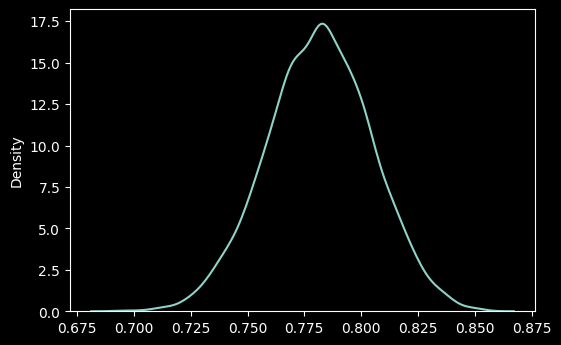

In [52]:
sns.kdeplot(s['th'])

# 5.5 Censored Data

In [53]:
import truncBinom as tbc

(950,) (950,) (950,) (950,)


sample: 100%|██████████| 6000/6000 [00:07<00:00, 788.77it/s, 1 steps of size 8.32e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.39      0.00      0.39      0.39      0.39   1661.45      1.00

Number of divergences: 0
(array([  13,   57,  288,  812, 1220, 1325,  878,  333,   66,    8]), array([0.38320002, 0.38469583, 0.3861916 , 0.3876874 , 0.3891832 ,
       0.390679  , 0.3921748 , 0.3936706 , 0.3951664 , 0.39666218,
       0.39815798], dtype=float32))


In [54]:
jnp.repeat(1/10., 4)

DeviceArray([0.1, 0.1, 0.1, 0.1], dtype=float32)

In [55]:
def model55_1(n_q=50, yobs=30, n_failed=949, low=15, high=25):
    theta = numpyro.sample('theta', dist.Uniform(low=.25, high=1.))
    failed_probs = jnp.repeat(1./(high-low+1), high-low+1)
    
    # truncated observations
    # I randomly choose those failed observations
    with numpyro.plate('f:{n_failed}', size=n_failed):  
        failed_k = numpyro.sample('f', dist.Categorical(probs=failed_probs))
        failed = numpyro.deterministic('failed', failed_k + low)
        
    with numpyro.plate(f'N:{n_failed}', size=n_failed):
        y_unobs = numpyro.sample('yf', tbc.TruncatedBinomial(total_count=n_q, probs=theta, low=low, high=high), obs=failed)

    # truely observed case
    y = numpyro.sample('y', dist.Binomial(total_count=n_q, probs=theta), obs=yobs)
#

In [56]:
n_q = 50  # number of questions
yobs = 30 
n_failed = 949

In [57]:
rng_key, sub = jax.random.split(rng_key)
mcmc = mcmcinfer(model55_1)

sample: 100%|██████████| 6000/6000 [00:27<00:00, 219.02it/s, 3 steps of size 8.90e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.30      0.00      0.30      0.30      0.30   1783.13      1.00

Number of divergences: 0


In [89]:
samples = mcmc.get_samples()
samples, samples['failed'].shape

({'failed': DeviceArray([[16, 20, 24, ..., 20, 22, 15],
               [16, 20, 24, ..., 20, 22, 15],
               [16, 20, 24, ..., 20, 22, 15],
               ...,
               [16, 20, 24, ..., 20, 22, 15],
               [16, 20, 24, ..., 20, 22, 15],
               [16, 20, 24, ..., 20, 22, 15]], dtype=int32),
  'theta': DeviceArray([0.29710513, 0.2978908 , 0.2978908 , ..., 0.29925054,
               0.29876098, 0.3025375 ], dtype=float32)},
 (5000, 949))

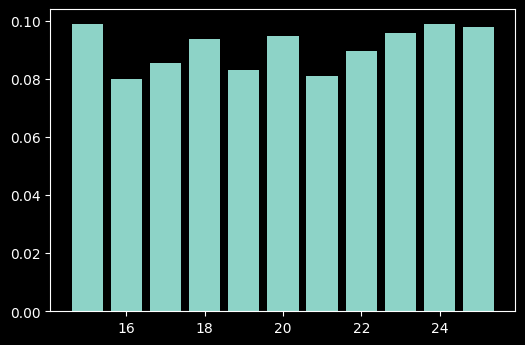

In [173]:
phist(samples['failed'][0,:])

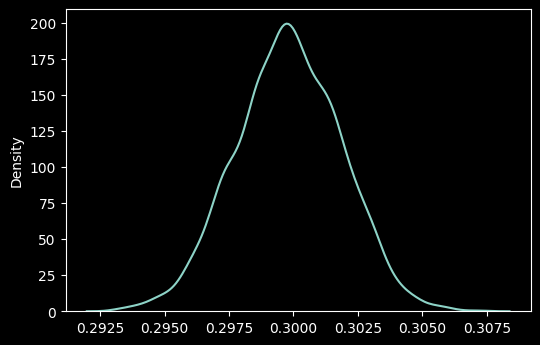

In [91]:
sns.kdeplot(samples['theta']);

---

In [35]:
def model55_2(fobs, sobs, nqs, low, high):
    theta = numpyro.sample('theta', dist.Uniform(low=.25, high=1.))
    
    with numpyro.plate(f'fobs_N:{len(fobs)}', size=len(fobs)):
        fy = numpyro.sample('fy', tbc.TruncatedBinomial(total_count=nqs, probs=theta, low=low, high=high), obs=fobs)
        
    with numpyro.plate(f'N:{len(sobs)}', size=len(sobs)):
        sy = numpyro.sample('sy', dist.Binomial(total_count=nqs, probs=theta), obs=sobs)
#

In [38]:
low = 15
high = 25
nqs = 50
n_failed = 3

rng_key, sub = jax.random.split(rng_key)
fobs = jax.random.choice(rng_key, jnp.arange(low, high+1), shape=(n_failed,))

sobs = jnp.array([30])

In [40]:
rng_key, sub = jax.random.split(rng_key)
args = dict(fobs=fobs, sobs=sobs, nqs=nqs, low=low, high=high)
mcmc = mcmcinfer(model55_2, args)

NameError: name 'tbc' is not defined

In [152]:
s = mcmc.get_samples()
s

{'theta': DeviceArray([0.38978586, 0.38992566, 0.38995036, ..., 0.39066428,
              0.390407  , 0.38964707], dtype=float32)}

<AxesSubplot:ylabel='Density'>

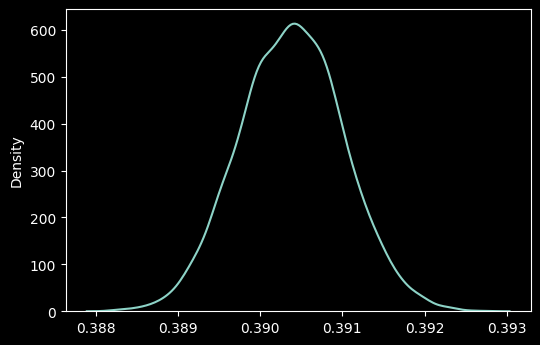

In [128]:
sns.kdeplot(s['theta'])